In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
#import missingno as msno
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel, kstest
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from sklearn.impute import KNNImputer
#import fancyimpute as fi

#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
import pandas
pandas.__version__

'1.0.5'

In [3]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [4]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [5]:
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures'

In [6]:
data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data'
df = pd.read_csv(join(data_dir, 'rescored', 'physics_learning-nonbrain_OLS-missing.csv'), 
                 index_col=0, header=0)

In [7]:
post_iq = ['VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2']
delta_iq = ['deltaVCI', 'deltaPRI', 'deltaWMI', 'deltaPSI', 'deltaFSIQ']
iq_vars = post_iq + delta_iq

In [8]:
#rsgt_df = pd.read_csv(join(data_dir, 'resting-state_graphtheory_shen+craddock_2019-05-29.csv'), 
#                      index_col=0, header=0)
#rsgt_df = pd.read_csv(join(data_dir, 'output', 'resting-state_graphtheory_shen+craddock_2019-11-20.csv'), 
#                      index_col=0, header=0)
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [9]:
fd = pd.read_csv(join(data_dir, 'avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
#reas_fd = fd[fd['task'] == 'reas']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

#df_pivot = reas_fd[reas_fd['condition'] == 'high-level'].reset_index()
#reas_inf_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
#reas_inf_fd.rename({'pre': 'pre infr reas fd', 'post': 'post infr reas fd'}, axis=1, inplace=True)

#df_pivot = reas_fd[reas_fd['condition'] == 'lower-level'].reset_index()
#reas_base_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
#reas_base_fd.rename({'pre': 'pre base reas fd', 'post': 'post base reas fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

rest_fd = pd.read_csv(join(data_dir, 'avg-fd-per-run-rest_2019-05-31.csv'), index_col=0, header=0)
rs_fd = rest_fd.reset_index().pivot(index='subject', columns='session', values='average fd')
rs_fd.rename({'pre': 'pre rest fd', 'post': 'post rest fd'}, axis=1, inplace=True)

In [10]:
fci_df = pd.read_csv(join(data_dir, 
                          'physics-learning-fci_graphtheory_shen+craddock_2019-05-31.csv'), 
                     index_col=0, header=0)

phys_fci = fci_df[fci_df['condition'] == 'high-level']
ctrl_fci = fci_df[fci_df['condition'] == 'lower-level']

#physics fci measures per session per parcellation
df_pivot = phys_fci[phys_fci['mask'] == 'shen2015'].reset_index()
shen_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_phys_fci_df.rename({0: 'pre phys fci shen eff', 1: 
                             'post phys fci shen eff'}, 
                            axis=1, inplace=True)

#shen_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#shen_cpl_phys_fci_df.rename({0: 'pre phys fci shen cpl', 1: 'post phys fci shen cpl'}, axis=1, inplace=True)

shen_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_phys_fci_df.rename({0: 'pre phys fci shen mod', 1: 'post phys fci shen mod'}, axis=1, inplace=True)

df_pivot = phys_fci[phys_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_phys_fci_df.rename({0: 'pre phys fci crad eff', 1: 'post phys fci crad eff'}, axis=1, inplace=True)

#crad_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#crad_cpl_phys_fci_df.rename({0: 'pre phys fci crad cpl', 1: 'post phys fci crad cpl'}, axis=1, inplace=True)

crad_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_phys_fci_df.rename({0: 'pre phys fci crad mod', 1: 'post phys fci crad mod'}, axis=1, inplace=True)


#ctrl fci measures per session per parcellation
df_pivot = ctrl_fci[ctrl_fci['mask'] == 'shen2015'].reset_index()
shen_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_ctrl_fci_df.rename({0: 'pre ctrl fci shen eff', 1: 'post ctrl fci shen eff'}, axis=1, inplace=True)

#shen_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#shen_cpl_ctrl_fci_df.rename({0: 'pre ctrl fci shen cpl', 1: 'post ctrl fci shen cpl'}, axis=1, inplace=True)

shen_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_ctrl_fci_df.rename({0: 'pre ctrl fci shen mod', 1: 'post ctrl fci shen mod'}, axis=1, inplace=True)

df_pivot = ctrl_fci[ctrl_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_ctrl_fci_df.rename({0: 'pre ctrl fci crad eff', 1: 'post ctrl fci crad eff'}, axis=1, inplace=True)

#crad_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#crad_cpl_ctrl_fci_df.rename({0: 'pre ctrl fci crad cpl', 1: 'post ctrl fci crad cpl'}, axis=1, inplace=True)

crad_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_ctrl_fci_df.rename({0: 'pre ctrl fci crad mod', 1: 'post ctrl fci crad mod'}, axis=1, inplace=True)

In [11]:
task_df = pd.read_csv(join(data_dir, 'physics-learning-tasks_graphtheory_shen+craddock_2019-05-30.csv'), index_col=0, header=0)
retr_df = task_df[task_df['task'] == 'retr']
retr_phys_df = retr_df[retr_df['condition'] == 'high-level']
genr_phys_df = retr_df[retr_df['condition'] == 'lower-level']

#physics retrieval measures per session per parcellation
df_pivot = retr_phys_df[retr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_phys_df.rename({0: 'pre phys retr shen eff', 1: 'post phys retr shen eff'}, axis=1, inplace=True)

#shen_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#shen_cpl_retr_phys_df.rename({0: 'pre phys retr shen cpl', 1: 'post phys retr shen cpl'}, axis=1, inplace=True)

shen_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_phys_df.rename({0: 'pre phys retr shen mod', 1: 'post phys retr shen mod'}, axis=1, inplace=True)

df_pivot = retr_phys_df[retr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_phys_df.rename({0: 'pre phys retr crad eff', 1: 'post phys retr crad eff'}, axis=1, inplace=True)

#crad_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#crad_cpl_retr_phys_df.rename({0: 'pre phys retr crad cpl', 1: 'post phys retr crad cpl'}, axis=1, inplace=True)

crad_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_phys_df.rename({0: 'pre phys retr crad mod', 1: 'post phys retr crad mod'}, axis=1, inplace=True)

#general retrieval measures per session per parcellation
df_pivot = genr_phys_df[genr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_genr_df.rename({0: 'pre gen retr shen eff', 1: 'post gen retr shen eff'}, axis=1, inplace=True)

#shen_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#shen_cpl_retr_genr_df.rename({0: 'pre gen retr shen cpl', 1: 'post gen retr shen cpl'}, axis=1, inplace=True)

shen_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_genr_df.rename({0: 'pre gen retr shen mod', 1: 'post gen retr shen mod'}, axis=1, inplace=True)

df_pivot = genr_phys_df[genr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_genr_df.rename({0: 'pre gen retr crad eff', 1: 'post gen retr crad eff'}, axis=1, inplace=True)

#crad_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
#crad_cpl_retr_genr_df.rename({0: 'pre gen retr crad cpl', 1: 'post gen retr crad cpl'}, axis=1, inplace=True)

crad_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_genr_df.rename({0: 'pre gen retr crad mod', 1: 'post gen retr crad mod'}, axis=1, inplace=True)

reas_df = task_df[task_df['task'] == 'reas']
reas_infr_df = reas_df[reas_df['condition'] == 'high-level']
reas_base_df = reas_df[reas_df['condition'] == 'lower-level']

#infrics reasieval measures per session per parcellation
df_pivot = reas_infr_df[reas_infr_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_infr_df.rename({0: 'pre infr reas shen eff', 1: 'post infr reas shen eff'}, axis=1, inplace=True)

shen_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_infr_df.rename({0: 'pre infr reas shen cpl', 1: 'post infr reas shen cpl'}, axis=1, inplace=True)

shen_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_infr_df.rename({0: 'pre infr reas shen mod', 1: 'post infr reas shen mod'}, axis=1, inplace=True)

df_pivot = reas_infr_df[reas_infr_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_infr_df.rename({0: 'pre infr reas crad eff', 1: 'post infr reas crad eff'}, axis=1, inplace=True)

crad_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_infr_df.rename({0: 'pre infr reas crad cpl', 1: 'post infr reas crad cpl'}, axis=1, inplace=True)

crad_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_infr_df.rename({0: 'pre infr reas crad mod', 1: 'post infr reas crad mod'}, axis=1, inplace=True)

#baseeral reasieval measures per session per parcellation
df_pivot = reas_base_df[reas_base_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_base_df.rename({0: 'pre base reas shen eff', 1: 'post base reas shen eff'}, axis=1, inplace=True)

shen_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_base_df.rename({0: 'pre base reas shen cpl', 1: 'post base reas shen cpl'}, axis=1, inplace=True)

shen_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_base_df.rename({0: 'pre base reas shen mod', 1: 'post base reas shen mod'}, axis=1, inplace=True)

df_pivot = reas_base_df[reas_base_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_base_df.rename({0: 'pre base reas crad eff', 1: 'post base reas crad eff'}, axis=1, inplace=True)

crad_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_base_df.rename({0: 'pre base reas crad cpl', 1: 'post base reas crad cpl'}, axis=1, inplace=True)

crad_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_base_df.rename({0: 'pre base reas crad mod', 1: 'post base reas crad mod'}, axis=1, inplace=True)

In [12]:
#demo_df[demo_df['Strt.Level'] < 0] = np.nan

In [13]:
all_df = pd.concat((df, head_size['normalized head size'],
                    shen_eff_retr_phys_df, shen_mod_retr_phys_df,
                    crad_eff_retr_phys_df, crad_mod_retr_phys_df, 
                    shen_eff_retr_genr_df, shen_mod_retr_genr_df, 
                    crad_eff_retr_genr_df, crad_mod_retr_genr_df,
                    shen_eff_phys_fci_df, shen_mod_phys_fci_df,
                    crad_eff_phys_fci_df, crad_mod_phys_fci_df,
                    shen_eff_ctrl_fci_df, shen_mod_ctrl_fci_df,
                    crad_eff_ctrl_fci_df, crad_mod_ctrl_fci_df, 
                    retr_phys_fd, retr_genr_fd, fci_phys_fd, fci_ctrl_fd), axis=1)

missing_df = pd.DataFrame(columns=all_df.keys(), index=all_df.index)

for key in missing_df.keys():
    missing_df[key] = all_df[key].isnull()

missing_df.replace({False: 0, True:1}, inplace=True)


In [14]:
null_df = pd.read_csv(join(data_dir, 'output', 'local_efficiency/null_dist_effs.csv'), 
                   header=0, index_col=[0,1,2,3])
null_df.head()

mean      sdev
pre retr physics shen2015      0.027092  0.000059
                 craddock2012  0.028314  0.000019
         control shen2015      0.029660  0.000008
                 craddock2012  0.030781  0.000048
    fci  physics shen2015      0.023679  0.000008

In [15]:
masks = {'shen2015': 'shen', 'craddock2012': 'crad'}
tasks = ['fci', 'retr']

for mask in masks.keys():
    for task in tasks:
        null = null_df.loc['post', task, 'physics', mask]['mean']
        vals = all_df['post phys {0} {1} eff'.format(task, masks[mask])]
        all_df['post phys {0} {1} eff'.format(task, masks[mask])] = vals / null
all_df['F'] = all_df['F'] - 0.5


In [16]:
impute_pls = KNNImputer(n_neighbors=3, weights='distance')
ols_imputed = impute_pls.fit_transform(all_df)
imp_df = pd.DataFrame(ols_imputed, columns=all_df.columns, index=all_df.index)

In [17]:
index = pd.MultiIndex.from_product([missing_df.keys(), all_df.keys()])
mnar = pd.DataFrame(columns=['corr', 'pval'], index=index)

In [18]:
sexes = ['Male', 'Female', 'All']
sessions = ['pre', 'post', 'delta']

In [19]:
imp_df.columns = imp_df.columns.str.replace(' ', '_')

In [20]:
imp_df.to_csv(join(data_dir, 'rescored', 'physics_learning-plus+brain_OLS-missing.csv'))

In [21]:
#compute deltas
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']
for iq in iqs:
    imp_df['{0}2_sd'] = 
    imp_df['delta{0}'.format(iq)] = imp_df['{0}2'.format(iq)] - imp_df['{0}1'.format(iq)]
    imp_df['delta{0}'.format(iq)] = imp_df['delta{0}'.format(iq)] / 

# For all students, all together, how is topology related to IQ?

In [22]:
#first things first, setting up our covariates
covariates = ['Age', 'Mod', 'StrtLvl', 'normalized head size', 'SexXClass', 'F']

In [23]:
outcomes1 = ['post_phys_retr_crad_eff', 'post_phys_retr_crad_mod',
             'post_phys_retr_shen_eff', 'post_phys_retr_shen_mod']
outcomes2 = ['post_phys_fci_shen_eff', 'post_phys_fci_shen_mod',
             'post_phys_fci_crad_eff', 'post_phys_fci_crad_mod']

all_out = outcomes1 + outcomes2

adj_a,_ = liji_sidak_mc(imp_df[all_out], 0.01)
print('Shen', adj_a)

Number of effective comparisons: 3.631862050518683
Critical value of 0.010 becomes 0.002763 after corrections
Shen 0.002763442703913488


## OLS Regressions

In [24]:
iterables = {'tasks': ['fci', 'retr'],
             'masks': ['crad', 'shen'],
             'metrics': ['mod', 'eff'], 
             'iq_vars': iq_vars}

In [25]:
simple = {}
intrxn = {}
compar = {}
for task in iterables['tasks']:
    for mask in iterables['masks']:
        for metric in iterables['metrics']:
            for iq_meas in iterables['iq_vars']:
                reg_form = '''post_phys_{0}_{1}_{2} ~ 
                                {3} + F + Mod + F*Mod + Age + StrtLvl 
                                + normalized_head_size + post_phys_{0}_fd'''.format(task,
                                                                                    mask,
                                                                                    metric,
                                                                                    iq_meas)
                mod = smf.ols(formula=reg_form, data=imp_df)
                res = mod.fit()
                simple['{0}_{1}_{2}_{3}'.format(task,
                                                 mask,
                                                 metric,
                                                 iq_meas)] = res

                if res.get_robustcov_results().f_pvalue <= adj_a:
                    print('\n*{0}_{1}_{2} on {3} fci_simple model IS significant'.format(task,
                                                                                         mask,
                                                                                         metric,
                                                                                         iq_meas))
                    if res.get_robustcov_results().pvalues[1] < 0.05:
                        print('* and {0} coefficient significant, too!'.format(iq_meas))
                    else:
                        print('x but {0} coefficient not significant.'.format(iq_meas))
                #else:
                    #print('\n{0} on {1} fci_simple model NOT significant'.format(outcome, iq_meas))

                itx_form = '''post_phys_{0}_{1}_{2} ~ {3} + {3}*F + {3}*Mod + {3}*F*Mod 
                                + F + Mod + F*Mod + Age + StrtLvl + 
                                normalized_head_size + post_phys_{0}_fd'''.format(task, 
                                                                                  mask, 
                                                                                  metric, 
                                                                                  iq_meas)   
                mod = smf.ols(formula=itx_form, data=imp_df)
                res2 = mod.fit()
                intrxn['{0}_{1}_{2}_{3}'.format(task,
                                                mask,
                                                metric,
                                                iq_meas)] = res2

                if res2.get_robustcov_results().f_pvalue <= adj_a:
                    print('*{0}_{1}_{2} on {3} interaction model IS significant'.format(task, mask, metric, iq_meas))
                    if res2.get_robustcov_results().pvalues[1] < 0.05:
                        print('* and {0} coefficient significant, too!'.format(iq_meas))
                    else:
                        print('x but {0} coefficient not significant.'.format(iq_meas))
                #else:
                    #print('{0} on {1} interaction model NOT significant'.format(outcome, iq_meas))

                compare = anova_lm(res.get_robustcov_results(), res2.get_robustcov_results())
                compar['{0}_{1}_{2}_{3}'.format(task,
                                                mask,
                                                metric,
                                                iq_meas)] = compare
                if compare['Pr(>F)'][1] <= 0.05:
                    print(np.round(compare['Pr(>F)'][1], 3), 
                          'interaction model fits better than nested model for {0}_{1}_{2} ~ {3}'.format(task, 
                                                                                                 mask, 
                                                                                                 metric, 
                                                                                                 iq_meas))
                elif compare['Pr(>F)'][0] <= 0.05:
                    print('Nested model fits better than interaction model for {0}_{1}_{2} ~ {3}'.format(task, 
                                                                                                         mask, 
                                                                                                         metric, 
                                                                                                         iq_meas))
                #else:
                    #print(np.round(fci_compare['Pr(>F)'][1], 3), 'no difference between models')

*fci_crad_eff on PRI2 interaction model IS significant
x but PRI2 coefficient not significant.
0.036 interaction model fits better than nested model for fci_crad_eff ~ PRI2
0.018 interaction model fits better than nested model for fci_crad_eff ~ WMI2
*fci_crad_eff on FSIQ2 interaction model IS significant
x but FSIQ2 coefficient not significant.
0.01 interaction model fits better than nested model for fci_crad_eff ~ FSIQ2
0.02 interaction model fits better than nested model for fci_crad_eff ~ deltaPRI
*fci_crad_eff on deltaFSIQ interaction model IS significant
x but deltaFSIQ coefficient not significant.
0.008 interaction model fits better than nested model for fci_crad_eff ~ deltaFSIQ
*fci_shen_mod on deltaFSIQ interaction model IS significant
x but deltaFSIQ coefficient not significant.
*fci_shen_eff on PRI2 interaction model IS significant
x but PRI2 coefficient not significant.
0.022 interaction model fits better than nested model for fci_shen_eff ~ PRI2
0.018 interaction model fit

In [26]:
columns = ['Model F (p)', 'BIC', 'WAIS-IV',
           'Sex (F)', 'Class (Active)', 'Sex X Class', 
           'Age', 'Years in Univ.']

mi = pd.MultiIndex.from_product([iterables['tasks'], 
                                 iterables['masks'],
                                 iterables['metrics'], 
                                 iterables['iq_vars']])
df_res_simple = pd.DataFrame(columns=columns, index=mi)

for key in simple.keys():
    keys = key.split('_')
    summ = simple[key].get_robustcov_results()
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Model F (p)'] = '{0} ({1})'.format(np.round(summ.fvalue[0][0],3),
                                                         np.format_float_scientific(summ.f_pvalue, 
                                                                                    precision=3,
                                                                                    exp_digits=2))
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'BIC'] = np.round(summ.bic,1)
    if summ.pvalues[1] < 0.01:
        dec = '**'
    elif summ.pvalues[1] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'WAIS-IV'] = '{0}{1}'.format(np.round(summ.params[1], 3), dec)
    if summ.pvalues[2] < 0.01:
        dec = '**'
    elif summ.pvalues[2] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Sex (F)'] = '{0}{1}'.format(np.round(summ.params[2], 3), dec)
    if summ.pvalues[3] < 0.01:
        dec = '**'
    elif summ.pvalues[3] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Class (Active)'] = '{0}{1}'.format(np.round(summ.params[3], 3), dec)
    if summ.pvalues[4] < 0.01:
        dec = '**'
    elif summ.pvalues[4] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Sex X Class'] = '{0}{1}'.format(np.round(summ.params[4], 3), dec)
    if summ.pvalues[5] < 0.01:
        dec = '**'
    elif summ.pvalues[5] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Age'] = '{0}{1}'.format(np.round(summ.params[5], 3), dec)
    if summ.pvalues[6] < 0.01:
        dec = '**'
    elif summ.pvalues[6] < 0.051:
        dec = '*'
    else:
        dec=''
    df_res_simple.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Years in Univ.'] = '{0}{1}'.format(np.round(summ.params[6], 3), dec)
    

df_res_simple.to_csv(join(data_dir, 'output', 'brain_metrics~iq-ols_robust-knn_imp-simple.csv'))
df_res_simple.head()

<bound method NDFrame.head of                                Model F (p)     BIC WAIS-IV Sex (F)  \
fci  crad mod VCI2       1.396 (2.048e-01) -1085.2     0.0     0.0   
              PRI2       1.403 (2.019e-01) -1085.6     0.0     0.0   
              WMI2       1.667 (1.132e-01) -1087.1     0.0     0.0   
              PSI2       1.416 (1.964e-01) -1085.5     0.0     0.0   
              FSIQ2       1.59 (1.347e-01) -1086.6     0.0     0.0   
...                                    ...     ...     ...     ...   
retr shen eff deltaVCI   1.918 (6.324e-02)  -114.8   0.001   0.001   
              deltaPRI   2.098 (4.098e-02)  -115.8   0.002  -0.003   
              deltaWMI    1.989 (5.33e-02)  -114.2  -0.001  -0.001   
              deltaPSI    1.99 (5.319e-02)  -114.2    -0.0    -0.0   
              deltaFSIQ  1.936 (6.051e-02)  -115.1   0.002     0.0   

                        Class (Active) Sex X Class    Age Years in Univ.  
fci  crad mod VCI2               0.001      -0.001   -

In [61]:
columns = ['Model F (p)', 'BIC', 'WAIS-IV', 'WAIS X Sex', 'WAIS X Class', 'WAIS X Sex X Class',
           'Sex (F)', 'Class (Active)', 'Sex X Class', 
           'Age', 'Years in Univ.', 'BetterThanSimple']
mi = pd.MultiIndex.from_product([iterables['tasks'], 
                                 iterables['masks'],
                                 iterables['metrics'], 
                                 iterables['iq_vars']])
df_res_intrxn = pd.DataFrame(columns=columns, index=mi)
do_i_make_figures = pd.DataFrame(columns=columns, index=mi)
resid_df = pd.DataFrame(columns=intrxn.keys(), index=imp_df.index)


for key in intrxn.keys():
    keys = key.split('_')
    if compar[key]['Pr(>F)'][1] < 0.01:
        df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                         'BetterThanSimple'] = compar[key]['Pr(>F)'][1]
    summ = intrxn[key].get_robustcov_results()
    resid_df[key] = intrxn[key].resid
    if summ.f_pvalue < adj_a:
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Model F (p)'] = 10
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Model F (p)'] = '{0} ({1})'.format(np.round(summ.fvalue[0][0],3),
                                                         np.format_float_scientific(summ.f_pvalue, 
                                                                                    precision=3,
                                                                                    exp_digits=2))
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'BIC'] = np.round(summ.bic,1)
    if summ.pvalues[1] < 0.01:
        dec = '**'
    elif summ.pvalues[1] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'WAIS-IV'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'WAIS-IV'] = '{0}{1}'.format(np.round(summ.params[1], 3), dec)
    if summ.pvalues[2] < 0.01:
        dec = '**'
    elif summ.pvalues[2] < 0.051:
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Sex (F)'] = 10
        dec = '*'
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Sex (F)'] = '{0}{1}'.format(np.round(summ.params[2], 3), dec)
    if summ.pvalues[3] < 0.01:
        dec = '**'
    elif summ.pvalues[3] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'WAIS X Sex'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'WAIS X Sex'] = '{0}{1}'.format(np.round(summ.params[3], 3), dec)
    if summ.pvalues[4] < 0.01:
        dec = '**'
    elif summ.pvalues[4] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Class (Active)'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Class (Active)'] = '{0}{1}'.format(np.round(summ.params[4], 3), dec)
    if summ.pvalues[5] < 0.01:
        dec = '**'
    elif summ.pvalues[5] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'WAIS X Class'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'WAIS X Class'] = '{0}{1}'.format(np.round(summ.params[5], 3), dec)
    if summ.pvalues[6] < 0.01:
        dec = '**'
    elif summ.pvalues[6] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Sex X Class'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Sex X Class'] = '{0}{1}'.format(np.round(summ.params[6], 3), dec)

    if summ.pvalues[7] < 0.01:
        dec = '**'
    elif summ.pvalues[7] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'WAIS X Sex X Class'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'WAIS X Sex X Class'] = '{0}{1}'.format(np.round(summ.params[7], 3), dec)
    
    if summ.pvalues[8] < 0.01:
        dec = '**'
    elif summ.pvalues[8] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Age'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Age'] = '{0}{1}'.format(np.round(summ.params[8], 3), dec)
    
    if summ.pvalues[9] < 0.01:
        dec = '**'
    elif summ.pvalues[9] < 0.051:
        dec = '*'
        do_i_make_figures.at[(keys[0], keys[1], keys[2], keys[3]), 
                             'Years in Univ.'] = 10
    else:
        dec = ''
    df_res_intrxn.at[(keys[0], keys[1], keys[2], keys[3]), 
                     'Years in Univ.'] = '{0}{1}'.format(np.round(summ.params[9], 3), dec)

    
df_res_intrxn.to_csv(join(data_dir, 'output', 'brain_metrics~iq-ols_robust-knn_imp-interaction.csv'))
df_res_intrxn.head()

Model F (p)     BIC WAIS-IV WAIS X Sex WAIS X Class  \
fci crad mod VCI2   1.188 (3.024e-01) -1073.9     0.0       -0.0         -0.0   
             PRI2   1.501 (1.401e-01)   -1074     0.0       -0.0          0.0   
             WMI2   1.498 (1.412e-01) -1073.2     0.0        0.0          0.0   
             PSI2   1.187 (3.033e-01) -1073.2     0.0       -0.0          0.0   
             FSIQ2  1.282 (2.431e-01) -1074.4     0.0       -0.0         -0.0   

                   WAIS X Sex X Class Sex (F) Class (Active) Sex X Class  \
fci crad mod VCI2                 0.0   0.014          0.011      -0.013   
             PRI2                 0.0   0.009         -0.002      -0.007   
             WMI2                -0.0  -0.006           -0.0       0.004   
             PSI2                -0.0   0.004         -0.002       0.004   
             FSIQ2                0.0   0.016          0.007      -0.012   

                     Age Years in Univ. BetterThanSimple  
fci crad mod VCI2   -0.0         -0.001              NaN  
             PRI2   -0.0         -0.001              NaN  
             WMI2   -0.0         -0.001              NaN  
             PSI2   -0.0         -0.001              NaN  
             FSIQ2  -0.0         -0.001              NaN

In [62]:
do_i_make_figures.dropna(how='all').to_csv(join(data_dir, 'do_I_make_figs', 'FIGS-brain_metrics~iq-ols_robust-knn_imp-interaction.csv'))

# time for figures!

In [63]:
fig_df = pd.concat([imp_df, resid_df], axis=1)

In [64]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cerulean', 'Cornflower'])

In [67]:
fig_df.columns[20:]

Index(['pre_phys_retr_shen_eff', 'post_phys_retr_shen_eff',
       'pre_phys_retr_shen_mod', 'post_phys_retr_shen_mod',
       'pre_phys_retr_crad_eff', 'post_phys_retr_crad_eff',
       'pre_phys_retr_crad_mod', 'post_phys_retr_crad_mod',
       'pre_gen_retr_shen_eff', 'post_gen_retr_shen_eff',
       ...
       'retr_shen_eff_VCI2', 'retr_shen_eff_PRI2', 'retr_shen_eff_WMI2',
       'retr_shen_eff_PSI2', 'retr_shen_eff_FSIQ2', 'retr_shen_eff_deltaVCI',
       'retr_shen_eff_deltaPRI', 'retr_shen_eff_deltaWMI',
       'retr_shen_eff_deltaPSI', 'retr_shen_eff_deltaFSIQ'],
      dtype='object', length=125)

In [68]:
fig_df['post_phys_fci_crad_eff']

101    0.892244
102    1.052264
103    0.994046
104    0.982068
105    1.015773
         ...   
629    1.016924
630    1.077828
631    1.033203
633    1.027470
634    1.082988
Name: post_phys_fci_crad_eff, Length: 130, dtype: float64

# Physics Retrieval & PRIQ

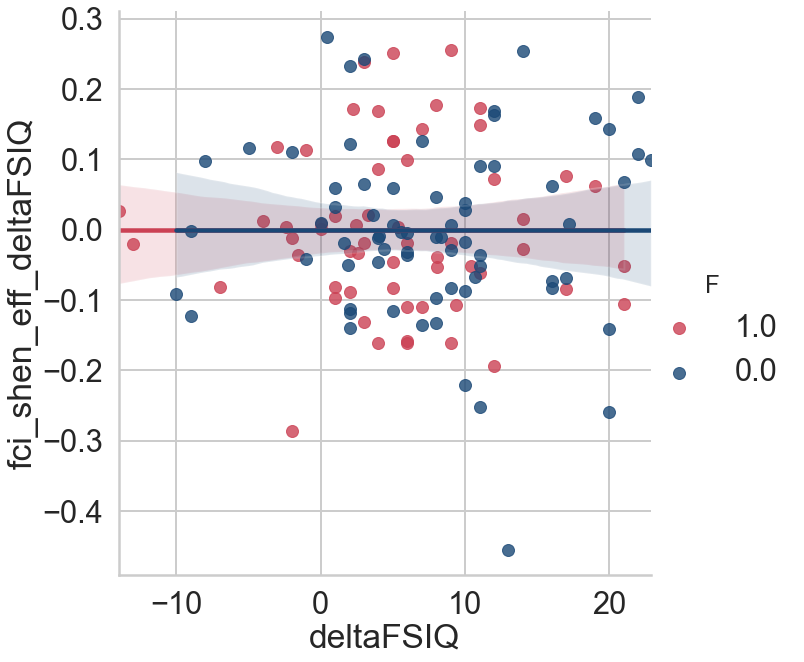

In [76]:
h = sns.lmplot('deltaFSIQ', 'fci_shen_eff_deltaFSIQ', data=fig_df, 
               hue='F', hue_order=[1.0,0.0], palette=crayons_d, height=10.)

#h.set_xlabels('Post-instruction perceptual reasoning')
#h.set_ylabels('Post-instruction efficiency')
#h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-priq_m.png'), dpi=300)

In [32]:
h = sns.lmplot('PRI2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-priq_f.png'), dpi=300)

NameError: name 'df_f' is not defined

# General retrieval and deltaPRIQ

In [ ]:
h = sns.lmplot('deltaPRI', 'post gen retr shen mod', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network modularity')
h.savefig(join(fig_dir, 'RETR_gen_post-modXdelta-priq_m.png'), dpi=300)

In [ ]:
h = sns.lmplot('deltaPRI', 'post gen retr shen mod', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network modularity')
h.savefig(join(fig_dir, 'RETR_gen_post-modXdelta-priq_f.png'), dpi=300)

# Physics Retrieval & FSIQ

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys retr shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-fsiq_m.png'), dpi=300)

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys retr shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
#h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-m.png'), dpi=300)

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction network-efficiency')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-fsiq_f.png'), dpi=300)

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
#h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-m.png'), dpi=300)

# FCI and PRIQ

In [ ]:
h = sns.lmplot('PRI2', 'post phys fci shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-priq_f.png'), dpi=300)

In [ ]:
h = sns.lmplot('PRI2', 'post phys fci shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-priq_m.png'), dpi=300)

# FCI and FSIQ

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys fci shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-fsiq_m.png'), dpi=300)

In [ ]:
h = sns.lmplot('FSIQ2', 'post phys fci shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-fsiq_f.png'), dpi=300)

In [ ]:
h = sns.lmplot('deltaFSIQ', 'post phys fci shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-fsiq_m.png'), dpi=300)

In [ ]:
h = sns.lmplot('deltaPRI', 'post phys fci shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-priq_m.png'), dpi=300)

In [ ]:
h = sns.lmplot('deltaFSIQ', 'post phys fci shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-fsiq_f.png'), dpi=300)

In [ ]:
h = sns.lmplot('deltaPRI', 'post phys fci shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-priq_f.png'), dpi=300)

# Reasoning and WMIQ

In [ ]:
h = sns.lmplot('WMI1', 'delta infr reas shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'REAS_infr_delta-effXpre-wmiq_f.png'), dpi=300)

In [ ]:
h = sns.lmplot('WMI1', 'delta infr reas shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'REAS_infr_delta-effXpre-wmiq_m.png'), dpi=300)

In [ ]:
import seaborn as sns
sns.set()